## Library Imports

In [3]:
import os
import sys
import time
import argparse
import json



import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd



from google.api_core.protobuf_helpers import get_messages
from google.cloud import storage

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/peterfagan/Desktop/gcp/waymo-2d-object-detection-514eeefdb0a3.json"

## Data Import

In [7]:
storage_client = storage.Client()
bucket = storage_client.get_bucket('waymo-raw-data')
blobs = bucket.list_blobs(prefix = 'waymo_open_dataset_v_1_2_0_individual_files/training/', delimiter='/')
metadata = []

In [8]:
for blob in blobs:
    print(blob.name)

waymo_open_dataset_v_1_2_0_individual_files/training/segment-10017090168044687777_6380_000_6400_000_with_camera_labels.tfrecord
waymo_open_dataset_v_1_2_0_individual_files/training/segment-10023947602400723454_1120_000_1140_000_with_camera_labels.tfrecord
waymo_open_dataset_v_1_2_0_individual_files/training/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord
waymo_open_dataset_v_1_2_0_individual_files/training/segment-10061305430875486848_1080_000_1100_000_with_camera_labels.tfrecord
waymo_open_dataset_v_1_2_0_individual_files/training/segment-10072140764565668044_4060_000_4080_000_with_camera_labels.tfrecord
waymo_open_dataset_v_1_2_0_individual_files/training/segment-10072231702153043603_5725_000_5745_000_with_camera_labels.tfrecord
waymo_open_dataset_v_1_2_0_individual_files/training/segment-10075870402459732738_1060_000_1080_000_with_camera_labels.tfrecord
waymo_open_dataset_v_1_2_0_individual_files/training/segment-10082223140073588526_6140_000_6160_000_with_

In [13]:
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)
    
    print(
        "Blob {} downloaded to {}.".format(
            source_blob_name, destination_file_name
        )
    )
    
    

client = storage.Client()
bucket = client.get_bucket('waymo-processed')

download_blob('waymo-processed',
              'train/images/2019-02-13/10017090168044687777_6380_000_6400_000/10017090168044687777_6380_000_6400_000_150_FRONT.jpeg',
              '/Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/example_1.jpeg')
download_blob('waymo-processed',
              'train/annotations/2019-02-13/10017090168044687777_6380_000_6400_000.json',
              '/Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/annotations.json')

Blob train/images/2019-02-13/10017090168044687777_6380_000_6400_000/10017090168044687777_6380_000_6400_000_150_FRONT.jpeg downloaded to /Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/example_1.jpeg.
Blob train/annotations/2019-02-13/10017090168044687777_6380_000_6400_000.json downloaded to /Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/annotations.json.


## Examine Annotations

In [11]:
# Read in image annotations
f = open('/Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/annotations.json','r')
annotations = json.load(f)
f.close()

## Plot Bounding Boxes

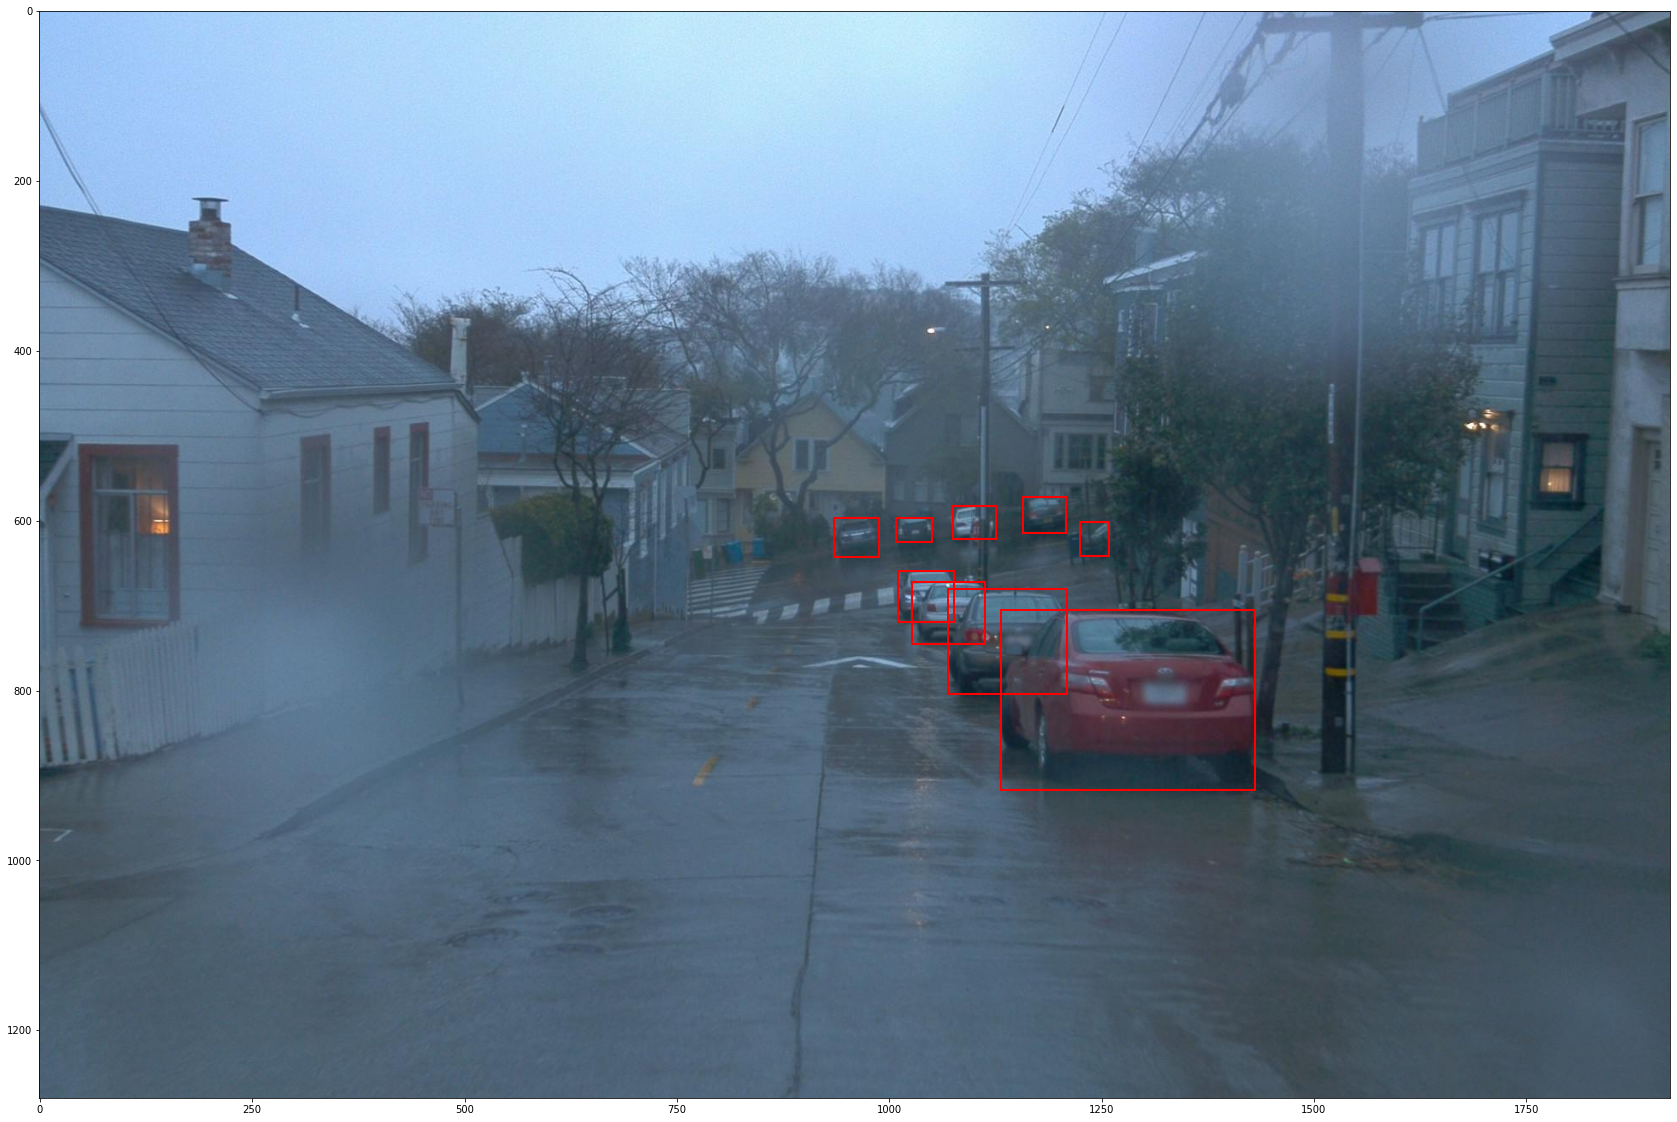

In [39]:
img = cv2.imread('/Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/example_1.jpeg')
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
anns = [x for x in annotations['annotations'] if x['image_id']=='10017090168044687777_6380_000_6400_000_150_FRONT']

# Create figure and axes
fig, ax = plt.subplots(figsize = (200,20))

# Display the image
ax.imshow(rgb_img)

for entry in anns:
    h = entry['bbox'][3]
    w = entry['bbox'][2]
    x = entry['bbox'][0]
    y = entry['bbox'][1]
    
    # Create a Rectangle patch
    rect = patches.Rectangle((x,y), h, w, linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()


# Import dataset locally

In [251]:
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print(
        "Blob {} downloaded to {}.".format(
            source_blob_name, destination_file_name
        )
    )

In [252]:
CATEGORY_NAMES = ['TYPE_VEHICLE','TYPE_PEDESTRIAN','TYPE_CYCLIST']
CATEGORY_IDS = [1,2,4]

class WaymoDataset(data.Dataset):
    def __init__(self, gcp_bucket, gcp_annotations_path, local_path_to_images, 
                 local_path_to_processed_images, cat_names, cat_ids):
        super(WaymoDataset, self).__init__()
        
        # filepaths
        self.gcp_bucket = gcp_bucket
        self.gcp_annotations_path = gcp_annotations_path
        self.local_path_to_images = local_path_to_images
        self.local_path_to_processed_images = local_path_to_processed_images
        
        # high level summary values
        self.num_classes = len(cat_names)
        self.category_names = cat_names
        self.category_ids = cat_ids
        
        
        # setup data directory
        if os.path.exists('./data')==False:
            os.mkdir('./data')
            os.mkdir(self.path_to_images)
            os.mkdir(self.path_to_processed_images)
        
        
        # read in annotations
        client = storage.Client()
        bucket = client.get_bucket(self.gcp_bucket)
        
        download_blob(self.gcp_bucket,
                           self.gcp_annotations_path,
                           './data/annotations.json')
        
        f = open('./data/annotations.json','r')
        self.annotations = json.load(f)
        f.close()
        
        # convert annotations to dataframe
        annotations_df = pd.DataFrame(annotations['annotations'])
        annotations_df['x'] = annotations_df['bbox'].apply(lambda x: x[0])
        annotations_df['y'] = annotations_df['bbox'].apply(lambda x: x[1])
        annotations_df['width'] = annotations_df['bbox'].apply(lambda x: x[2])
        annotations_df['height'] = annotations_df['bbox'].apply(lambda x: x[3])
        annotations_df.drop(columns='bbox')
        self.annotations_df = annotations_df

        
        # determine segment paths
        self.segment_paths = []
        for image in self.annotations['images']:
            uri = image['gcp_url']
            segment = '/'.join(uri.split('/')[3:7])+'/'
            if segment not in self.segment_paths:
                self.segment_paths.append(segment)
        
        
        # Download images for segments to local folder
#         for segment in self.segment_paths:
#             blobs = bucket.list_blobs(prefix=segment, delimiter='/')
#             for blob in list(blobs):
#                 filename=blob.name.replace(segment,'')
#                 blob.download_to_filename('./data/images/{}'.format(filename))


        # Preprocess images to be the same size
#         self.annotations_df = process_resizing(self.path_to_processed_images, annotations_df,800)
#         annotations_df['xn_min'] = annotations_df['new_bb'].apply(lambda x: x[0])
#         annotations_df['yn_min'] = annotations_df['new_bb'].apply(lambda x: x[1])
#         annotations_df['xn_max'] = annotations_df['new_bb'].apply(lambda x: x[2])
#         annotations_df['ym_max'] = annotations_df['new_bb'].apply(lambda x: x[3])
        
            
    def __getitem__(self, idx):
        image_url = self.annotations['images'][idx]['gcp_url']
        filename = image_url.split('/')[-1]
        image = Image.open(self.local_path_to_processed_images+'{}'.format(filename))
        image = np.asarray(img, dtype="float64") / 255.
        image = torch.tensor(image).permute(2,0,1)        
        
        return image
        
    
    def __len__(self):
        return len(annotations['images'])

In [253]:
dataset = WaymoDataset('waymo-processed','train/annotations/2019-02-13/10017090168044687777_6380_000_6400_000.json','./data/images/','./data/images_processed/', CATEGORY_NAMES, CATEGORY_IDS)
train_dataloader = data.DataLoader(dataset, batch_size=8)

Blob train/annotations/2019-02-13/10017090168044687777_6380_000_6400_000.json downloaded to ./data/annotations.json.


# Resizing images and bounding boxes

In [245]:
def annotations_to_df(annotations):
    df = pd.DataFrame(annotations['annotations'])
    df['filename'] = df['image_id'].apply(lambda x :os.getcwd()+'/data/images/{}.jpeg'.format(x))
    df['x_min'] = df['bbox'].apply(lambda x: x[0])
    df['y_min'] = df['bbox'].apply(lambda x: x[1])
    df['width'] = df['bbox'].apply(lambda x: x[2])
    df['height'] = df['bbox'].apply(lambda x: x[3])
    df['x_max'] = df['x_min'] + df['height']
    df['y_max'] = df['y_min'] + df['width']
    df.drop(columns='bbox',inplace=True)

    return df

def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(int)
    Y[bb[1]:bb[3], bb[0]:bb[2]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([top_row, left_col, bottom_row, right_col], dtype=np.float32)


def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = np.array(Image.open(read_path))
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    new_path = write_path + read_path.split('/')[-1]
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)


def process_resizing(resized_path, annotations_df, sz):
    new_paths = []
    new_bbs = []
    for index, row in annotations_df[['filename','x_min','y_min','x_max','y_max']].iterrows():
        new_path,new_bb = resize_image_bb(row['filename'], resized_path,
                                          np.array(row[['x_min','y_min','x_max','y_max']]),sz)
        new_paths.append(new_path)
        new_bbs.append(new_bb)
    annotations_df['processed_filepath'] = new_paths
    annotations_df['resized_bb'] = new_bbs
    annotations_df['xr_min'] = annotations_df['resized_bb'].apply(lambda x: x[0])
    annotations_df['yr_min'] = annotations_df['resized_bb'].apply(lambda x: x[1])
    annotations_df['xr_max'] = annotations_df['resized_bb'].apply(lambda x: x[2])
    annotations_df['yr_max'] = annotations_df['resized_bb'].apply(lambda x: x[3])
    annotations_df.drop(columns='resized_bb',inplace=True)
    
    
    return annotations_df    

In [246]:
annotations_df = annotations_to_df(dataset.annotations)
process_resizing('./data/images_processed/',annotations_df, 800)

id  category_id  \
0     12ba81ee-9cee-4134-94ca-df9ed01e0ff1            1   
1     2ab9ff55-a510-435b-a729-884444e67249            1   
2     470e3826-ecd2-425c-80ca-33f3d8c876a6            1   
3     98fcf17a-d19e-4c3b-bbc0-54ae2d1fcc15            1   
4     fb06fe05-95ee-43dc-801c-7855e4fbd7f1            1   
...                                    ...          ...   
4303  7df7020f-c391-4558-8e2e-96f3bc167846            1   
4304  820f2a5f-8cf8-4fdf-95ba-d41ad254b381            1   
4305  b4b2f300-3e2f-49fc-95e1-68840be870e8            1   
4306  fb33b618-2389-427b-bd05-71493d94e99c            1   
4307  737567d9-8186-4c3e-b762-9c295e8d1e8e            1   

                                               image_id          area  \
0        10017090168044687777_6380_000_6400_000_0_FRONT  26445.069597   
1        10017090168044687777_6380_000_6400_000_0_FRONT  27883.923280   
2        10017090168044687777_6380_000_6400_000_0_FRONT   5903.009924   
3        10017090168044687777_6380_000_6400_000_0_FRONT   1112.947539   
4        10017090168044687777_6380_000_6400_000_0_FRONT  46091.186556   
...                                                 ...           ...   
4303   10017090168044687777_6380_000_6400_000_197_FRONT   2714.155935   
4304   10017090168044687777_6380_000_6400_000_197_FRONT   3529.519652   
4305   10017090168044687777_6380_000_6400_000_197_FRONT   3600.126001   
4306   10017090168044687777_6380_000_6400_000_197_FRONT  21272.855334   
4307  10017090168044687777_6380_000_6400_000_197_SID...  34776.975423   

                                               filename        x_min  \
0     /Users/peterfagan/Code/herbie-vision/herbie_vi...  1346.234085   
1     /Users/peterfagan/Code/herbie-vision/herbie_vi...  1019.702055   
2     /Users/peterfagan/Code/herbie-vision/herbie_vi...  1150.756980   
3     /Users/peterfagan/Code/herbie-vision/herbie_vi...   991.912095   
4     /Users/peterfagan/Code/herbie-vision/herbie_vi...  1199.389410   
...                                                 ...          ...   
4303  /Users/peterfagan/Code/herbie-vision/herbie_vi...  1472.236290   
4304  /Users/peterfagan/Code/herbie-vision/herbie_vi...  1450.762230   
4305  /Users/peterfagan/Code/herbie-vision/herbie_vi...   609.168555   
4306  /Users/peterfagan/Code/herbie-vision/herbie_vi...  1066.123920   
4307  /Users/peterfagan/Code/herbie-vision/herbie_vi...   983.701425   

           y_min      width      height        x_max       y_max  \
0     437.691870  109.89666  240.635790  1586.869875  547.588530   
1     458.850135  156.00273  178.739970  1198.442025  614.852865   
2     471.481935   95.37009   61.895820  1212.652800  566.852025   
3     467.376600   39.15858   28.421550  1020.333645  506.535180   
4     540.009450  127.58118  361.269480  1560.658890  667.590630   
...          ...        ...         ...          ...         ...   
4303  480.955785   51.15879   53.053560  1525.289850  532.114575   
4304  516.956415   49.89561   70.738080  1521.500310  566.852025   
4305  591.484035   60.00105   60.001050   669.169605  651.485085   
4306  649.906110  127.58118  166.739760  1232.863680  777.487290   
4307  848.856960   37.14304  936.298575  1920.000000  886.000000   

                                     processed_filepath  xr_min  yr_min  \
0     ./data/images_processed/10017090168044687777_6...   561.0   273.0   
1     ./data/images_processed/10017090168044687777_6...   424.0   286.0   
2     ./data/images_processed/10017090168044687777_6...   479.0   294.0   
3     ./data/images_processed/10017090168044687777_6...   413.0   292.0   
4     ./data/images_processed/10017090168044687777_6...   499.0   337.0   
...                                                 ...     ...     ...   
4303  ./data/images_processed/10017090168044687777_6...   613.0   300.0   
4304  ./data/images_processed/10017090168044687777_6...   604.0   322.0   
4305  ./data/images_processed/10017090168044687777_6...   254.0   369.0   
4306  ./data/images_pr

In [224]:
# resized_img = cv2.resize(orig_img,(800,800))
# bb = np.array([example['x_min'][0],example['y_min'][0],
#               example['x_max'][0],example['y_max'][0]])
# mask = create_mask(bb,orig_img)
# resized_mask = cv2.resize(mask,(800,800))
# resized_bb = mask_to_bb(resized_mask)

# rect = patches.Rectangle((bb[0],bb[1]), h, w, linewidth=2, edgecolor='r', facecolor='none')


# # Create figure and axes
# fig, ax = plt.subplots(figsize = (200,20))

# # Display the image
# ax.imshow(resized_img)

# # Create a Rectangle patch
# rect = patches.Rectangle((resized_bb[1],resized_bb[0]), resized_bb[2]-resized_bb[0], resized_bb[3]-resized_bb[1], linewidth=2, edgecolor='r', facecolor='none')

# # Add the patch to the Axes
# ax.add_patch(rect)

# plt.show()

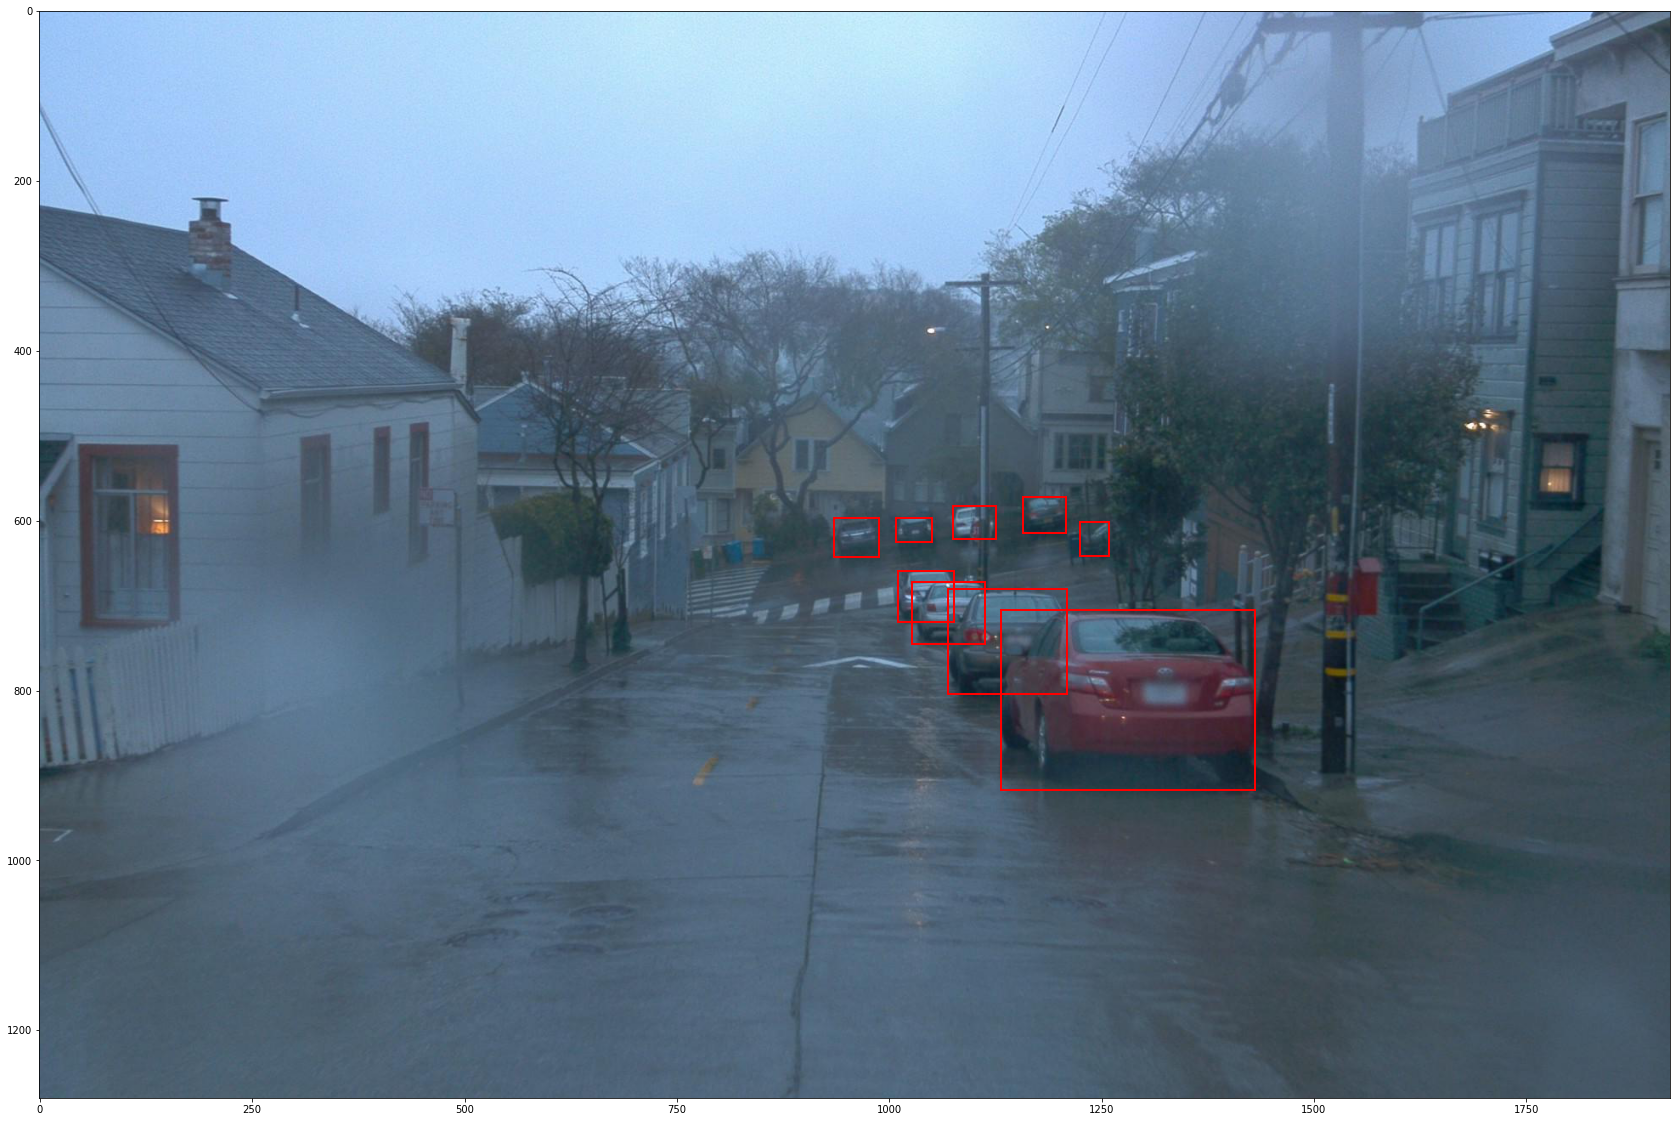

In [238]:
annotations_df = annotations_to_df(dataset.annotations)
example = annotations_df[annotations_df['image_id']=='10017090168044687777_6380_000_6400_000_150_FRONT'].reset_index()
orig_img = np.array(Image.open(example['filename'].unique()[0]))

def plot_w_annotations(img, annotations_df, resized=False):    
    # Create figure and axes
    fig, ax = plt.subplots(figsize = (200,20))
    
    # Display the image
    ax.imshow(img)

    for entry in annotations_df.iterrows():
        if resized==False:
            h = entry[1]['height']
            w = entry[1]['width']
            x = entry[1]['x_min']
            y = entry[1]['y_min']
        else:
            h = entry[1]['xr_max']-entry[1]['xr_min']
            w = entry[1]['yr_max']-entry[1]['yr_min']
            x = entry[1]['xr_min']
            y = entry[1]['yr_min']

        # Create a Rectangle patch
        rect = patches.Rectangle((x,y), h, w, linewidth=2, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()
    
plot_w_annotations(orig_img, example)

In [240]:
updated_df = process_resizing('./data/images_processed/', example, 800)

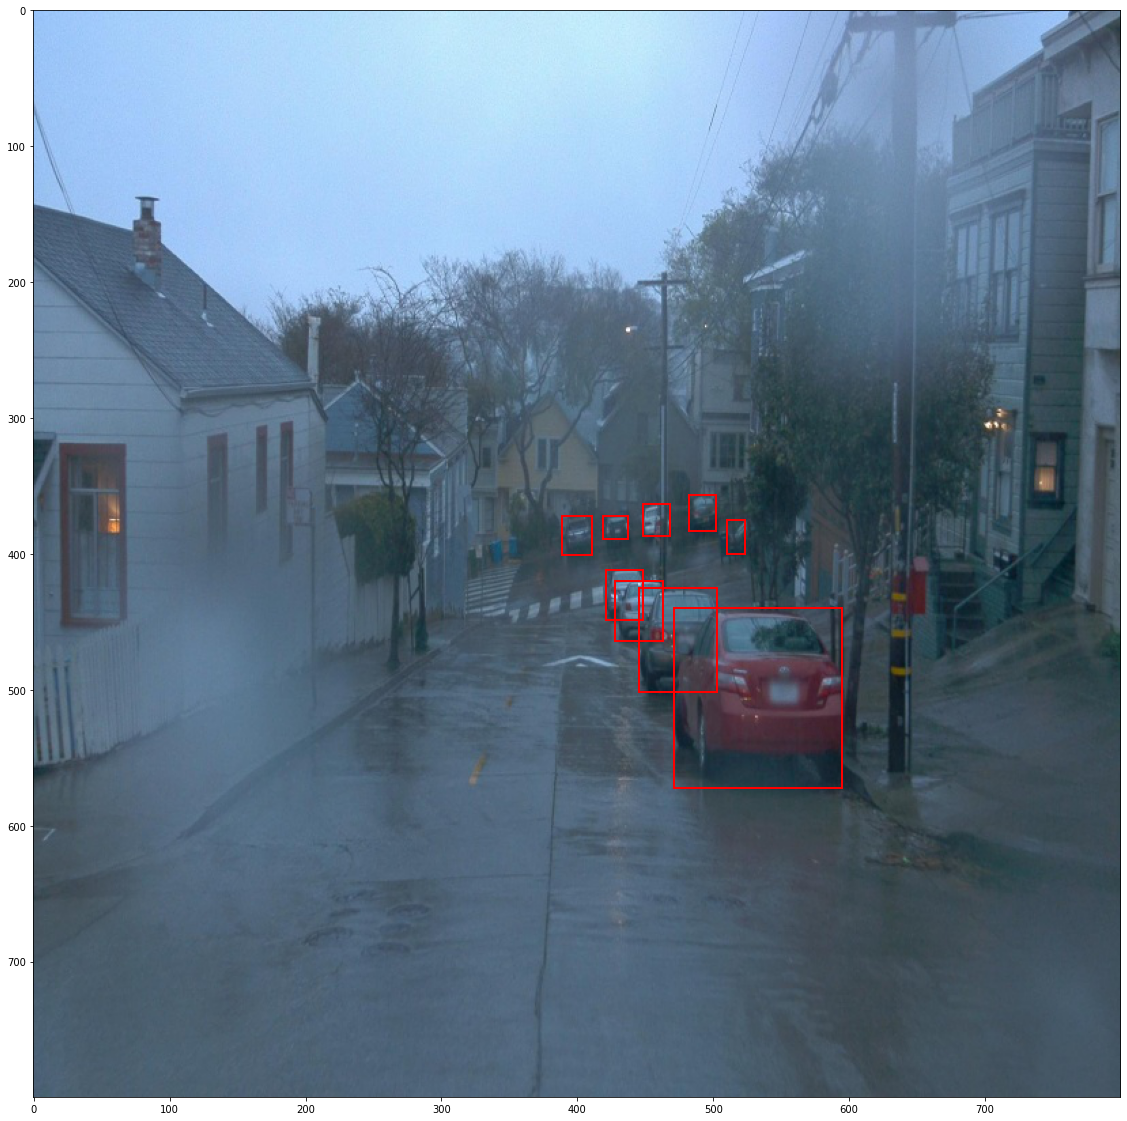

In [241]:
resized_img = np.array(Image.open(example['processed_filepath'].unique()[0]))
plot_w_annotations(resized_img, updated_df, resized=True)

In [169]:
resized_img = cv2.resize(orig_img,(800,800))
bb = np.array([example['x_min'][0],example['y_min'][0],
              example['x_max'][0],example['y_max'][0]])
mask = create_mask(bb,orig_img)
resized_mask = cv2.resize(mask,(800,800))
resized_bb = mask_to_bb(resized_mask)

# Refining Data Loader

In [3]:
import torch 

import os
from herbie_vision.utils.image import annotations_to_df, process_resizing
from herbie_vision.utils.gcp_utils import download_blob, upload_blob

CATEGORY_NAMES = ['TYPE_VEHICLE','TYPE_PEDESTRIAN','TYPE_CYCLIST']
CATEGORY_IDS = [1,2,4]

class WaymoDataset(data.Dataset):
    def __init__(self, gcp_bucket, gcp_annotations_path, local_path_to_images, 
                 local_path_to_processed_images, cat_names, cat_ids):
        super(WaymoDataset, self).__init__()
        
        # filepaths
        self.gcp_bucket = gcp_bucket
        self.gcp_annotations_path = gcp_annotations_path
        self.local_path_to_images = local_path_to_images
        self.local_path_to_processed_images = local_path_to_processed_images
        
        # high level summary values
        self.num_classes = len(cat_names)
        self.category_names = cat_names
        self.category_ids = cat_ids
        
        
        # setup data directory
        if os.path.exists('./data')==False:
            os.mkdir('./data')
            os.mkdir(self.path_to_images)
            os.mkdir(self.path_to_processed_images)
        
        
        # read in annotations
        client = storage.Client()
        bucket = client.get_bucket(self.gcp_bucket)
        
        download_blob(self.gcp_bucket,
                           self.gcp_annotations_path,
                           './data/annotations.json')
        
        f = open('./data/annotations.json','r')
        self.annotations = json.load(f)
        f.close()
        
        # convert annotations to dataframe
        self.annotations_df = annotations_to_df(self.annotations)

        
        # determine segment paths
#         self.segment_paths = []
#         for image in self.annotations['images']:
#             uri = image['gcp_url']
#             segment = '/'.join(uri.split('/')[3:7])+'/'
#             if segment not in self.segment_paths:
#                 self.segment_paths.append(segment)
        
        
        # Download images for segments to local folder
#         for segment in self.segment_paths:
#             blobs = bucket.list_blobs(prefix=segment, delimiter='/')
#             for blob in list(blobs):
#                 filename=blob.name.replace(segment,'')
#                 blob.download_to_filename('./data/images/{}'.format(filename))


#         # Drop images without annotations
        self.annotations['images'] = [x for x in self.annotations['images'] if x['id'] in self.annotations_df['image_id'].unique()]
        
#         # Preprocess images to be the same size
#         self.annotations_df = process_resizing(self.local_path_to_processed_images, self.annotations_df,800)
        
#         self.annotations_df.to_csv('./data/annotations.csv')

        self.annotations_df = pd.read_csv('./data/annotations.csv')
            
            
    def __getitem__(self, idx):
        image_id = self.annotations['images'][idx]['id']
        image_url = self.annotations['images'][idx]['gcp_url']
        filename = image_url.split('/')[-1]
        image = Image.open(self.local_path_to_processed_images+'{}'.format(filename))
        image = np.asarray(image, dtype="float64") / 255.
        image = torch.tensor(image).permute(2,0,1).float()        
        
        # define target data for fast rcnn
        temp_df = self.annotations_df[self.annotations_df['image_id']==image_id]

        boxes = []
        labels = []
        areas = []
        for _,item in temp_df.iterrows():
            boxes.append([item['xr_min'],item['yr_min'],item['xr_max'],item['yr_max']])
            labels.append(item['category_id'])
            areas.append(item['area'])
        
        boxes = torch.tensor(boxes)
        areas = torch.tensor(areas)
        labels = torch.tensor(labels)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = torch.zeros((temp_df.shape[0],), dtype=torch.int64)
        
        return image, target
    
    def __len__(self):
        return len(self.annotations['images'])

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = WaymoDataset('waymo-processed','train/annotations/2019-02-13/10017090168044687777_6380_000_6400_000.json','./data/images/','./data/images_processed/', CATEGORY_NAMES, CATEGORY_IDS)
test = data.Subset(dataset, indices=[1,2])
train_dataloader = data.DataLoader(test, batch_size=4, 
                                   shuffle=True, collate_fn=collate_fn)

Blob train/annotations/2019-02-13/10017090168044687777_6380_000_6400_000.json downloaded to ./data/annotations.json.


## Model Playground

### Faster rcnn

In [16]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Initialize model and set to eval mode
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# 2 classes; Only target class or background
num_classes = 3
num_epochs = 25
model = get_model_instance_segmentation(num_classes)

# move model to the right device
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(train_dataloader)



In [ ]:
for epoch in range(num_epochs):
    model.train()
    i = 0    
    for imgs, annotations in train_dataloader:
        i += 1
        imgs = list(img for img in imgs)
        annotations = [{k: v for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')



Iteration: 1/1, Loss: 1.9303377866744995
Iteration: 1/1, Loss: 1.888598918914795
Iteration: 1/1, Loss: 1.8290493488311768
Iteration: 1/1, Loss: 1.7419273853302002
Iteration: 1/1, Loss: 1.6109085083007812


In [ ]:
model.eval()


### Centernet

In [186]:
# instantiate model
model = exkp(n=5, nstack=2, dims=[256, 256, 384, 384, 384, 512], modules=[2, 2, 2, 2, 2, 4],num_classes=3)
model.train()

    
inputs = torch.randn(1,3,512,512)
outputs = model(inputs)
hmap_tl, hmap_br, hmap_ct, embd_tl, embd_br, regs_tl, regs_br, regs_ct = zip(*outputs)